In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import random
import time

import torch
import torchvision
import numpy as np
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
from torchvision import datasets, models, transforms
import json
import copy
import seaborn as sns
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import urllib.request
import progressbar
from os.path import exists

class ProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()
if not exists("./flower_data.tar.gz"):
    urllib.request.urlretrieve(" https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz", "flower_data.tar.gz", ProgressBar())
if not exists("./cat_to_name.json"):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/Muhammad-MujtabaSaeed/102-Flowers-Classification/master/cat_to_name.json", "cat_to_name.json",  ProgressBar())

In [3]:
import io
import os
import tarfile

def get_file_progress_file_object_class(on_progress):
    class FileProgressFileObject(tarfile.ExFileObject):
        def read(self, size, *args):
            on_progress(self.name, self.position, self.size)
            return tarfile.ExFileObject.read(self, size, *args)
    return FileProgressFileObject

class TestFileProgressFileObject(tarfile.ExFileObject):
    def read(self, size, *args):
        on_progress(self.name, self.position, self.size)
        return tarfile.ExFileObject.read(self, size, *args)

class ProgressFileObject(io.FileIO):
    def __init__(self, path, *args, **kwargs):
        self._total_size = os.path.getsize(path)
        io.FileIO.__init__(self, path, *args, **kwargs)

    def read(self, size):
        print(f"\rOverall process: [{self.tell()/self._total_size * 100:3.2f} %]", end='')
        return io.FileIO.read(self, size)

def on_progress(filename, position, total_size):
    print("%s: %d of %s" %(filename, position, total_size))

if not exists("./flowers"):
    tarfile.TarFile.fileobject = get_file_progress_file_object_class(on_progress)
    tar = tarfile.open(fileobj=ProgressFileObject("flower_data.tar.gz"))
    tar.extractall('./flowers')
    tar.close()

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
# Ensure deterministic behavior
def init_seeds(seed=0):
    torch.manual_seed(seed) # sets the seed for generating random numbers.
    torch.backends.cudnn.deterministic = True

init_seeds(1)
# Device configuration
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 Tesla V100-PCIE-32GB


In [5]:
import wandb

wandb.login()
os.environ["WANDB_API_KEY"] = "x"*40

config = dict(
    epochs          = 45,
    batch_size      = 32,
    learning_rate   = 0.1,
    gamma           = 0.1,
    step_size       = 30,
    classes         = 102,
    num_workers     = 4,
    dataset         = "Flowers102",
    model           = "resnet18",
    activation      = "relu",     # leaky relu/sigmoid/elu/tanh/relu
    optimizer       = "SGD",
)

wandb_init = dict(
#     job_type: Optional[str] = None,
#     dir = None,
    config = config,
    project = "Deep_Learning_HW1_Flowers102",
#     entity = None,
#     reinit = None,
    # tags = ['wgan_gp_1v1'],
#     group = None,
    name = None,
    notes = None,
#     magic = None,
#     config_exclude_keys = None,
#     config_include_keys = None,
#     anonymous = None,
    mode = "disabled",  # "online","offline","disabled"
#     allow_val_change = None,
#     resume = None,
#     force = None,
#     tensorboard = None,
#     sync_tensorboard = None,
#     monitor_gym = None,
    save_code = True,
#     settings=None
)
data_dir = './flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

wandb: Currently logged in as: ohmygoose0410. Use `wandb login --relogin` to force relogin


In [6]:
# defining data transforms for training, validation and test data and also normalizing whole data
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=config['batch_size'], shuffle=True, num_workers=config["num_workers"])
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [7]:
import json
with open('./cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

for i in range(0,len(class_names)):
    class_names[i] = cat_to_name.get(class_names[i])

In [8]:
import torch.optim as optim

def make(config):
    # loading a pre-trained(trained on image net) resnet18 model from torchvision models
    model_ft = models.resnet18(pretrained=True) 
    model_ft.layer1[0].relu = nn.ReLU()
    model_ft.layer1[1].relu = nn.ReLU()
    model_ft.layer2[0].relu = nn.ReLU()
    model_ft.layer2[1].relu = nn.ReLU()
    model_ft.layer3[0].relu = nn.ReLU()
    model_ft.layer3[1].relu = nn.ReLU()
    model_ft.layer4[0].relu = nn.ReLU()
    model_ft.layer4[1].relu = nn.ReLU()

    num_ftrs = model_ft.fc.in_features
    # changing the last layer for this dataset by setting last layer neurons to 102 as this dataset has 102 categories
    model_ft.fc = nn.Linear(num_ftrs, 102) 
    model_ft.to(device)

    # defining loss function
    criterion = nn.CrossEntropyLoss() 
     # defining optimizer with learning rate set to 0.0001
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=config["learning_rate"],
                             momentum=0.9, weight_decay=0.0001)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=config["step_size"], gamma=config["gamma"])
    
    return model_ft, criterion, optimizer_ft, scheduler

In [9]:
def test_model(model, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['test']
        epoch_acc = running_corrects.double() / dataset_sizes['test']
        print('\n\n' + '-' * 10)
        print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.4f}%')

In [10]:
def train_model(model, criterion, optimizer, scheduler, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    running_loss_avg = AverageMeter()
    best_acc = 0.0
    train_loss = 0
    running_loss_list = []
    since = time.time()
    print('-' * 60)
    for epoch in range(config["epochs"]):

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            tq = tqdm(total=(len(dataloaders[phase]) * config['batch_size']))
            tq.set_description(f'Epoch {epoch}, {phase}')

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):
                inputs = data[0].to(device)
                labels = data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_loss_avg.update(loss.cpu(), labels.size(0))

                tq.set_postfix(loss='{:.5f}'.format(running_loss_avg.avg), lr='{:1.10f}'.format(scheduler.get_last_lr()[0]))
                tq.update(config['batch_size'])
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            running_loss_list.append(epoch_loss)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.4f}%')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                wandb.log({"Average_training_loss": epoch_loss})
            else:
                wandb.log({"valid accuracy": epoch_acc})
            tq.close()    
        print('-' * 60)
        
    time_elapsed = time.time() - since
    wandb.log({"training time(s)": time_elapsed})
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc*100:4f}%')
    fig, ax = plt.subplots()
    ax.plot(running_loss_list, 'b')
    ax.set_title("Average Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
def visualize_model(model, num_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, data in enumerate(dataloaders['test']):
            inputs, labels = data
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

## Main

------------------------------------------------------------


Epoch 0, train: 100%|██████████| 6560/6560 [00:13<00:00, 484.41it/s, loss=5.72058, lr=0.1000000000] 


train Loss: 5.7206 Acc: 4.0140%


Epoch 0, valid: 100%|██████████| 832/832 [00:02<00:00, 339.81it/s, loss=5.56209, lr=0.1000000000]


valid Loss: 4.2926 Acc: 5.8680%
------------------------------------------------------------


Epoch 1, train: 100%|██████████| 6560/6560 [00:13<00:00, 484.34it/s, loss=4.90231, lr=0.1000000000]


train Loss: 4.1602 Acc: 5.5098%


Epoch 1, valid: 100%|██████████| 832/832 [00:02<00:00, 354.21it/s, loss=4.85134, lr=0.1000000000]


valid Loss: 3.9839 Acc: 7.9462%
------------------------------------------------------------


Epoch 2, train: 100%|██████████| 6560/6560 [00:13<00:00, 479.28it/s, loss=4.54923, lr=0.1000000000]


train Loss: 3.8696 Acc: 8.4249%


Epoch 2, valid: 100%|██████████| 832/832 [00:02<00:00, 383.80it/s, loss=4.51439, lr=0.1000000000]


valid Loss: 3.6076 Acc: 10.8802%
------------------------------------------------------------


Epoch 3, train: 100%|██████████| 6560/6560 [00:13<00:00, 488.23it/s, loss=4.31771, lr=0.1000000000]


train Loss: 3.6540 Acc: 10.9280%


Epoch 3, valid: 100%|██████████| 832/832 [00:02<00:00, 377.73it/s, loss=4.30016, lr=0.1000000000]


valid Loss: 3.6851 Acc: 11.6137%
------------------------------------------------------------


Epoch 4, train: 100%|██████████| 6560/6560 [00:13<00:00, 476.88it/s, loss=4.15228, lr=0.1000000000]


train Loss: 3.4869 Acc: 14.0873%


Epoch 4, valid: 100%|██████████| 832/832 [00:02<00:00, 373.69it/s, loss=4.13283, lr=0.1000000000]


valid Loss: 3.2763 Acc: 17.3594%
------------------------------------------------------------


Epoch 5, train: 100%|██████████| 6560/6560 [00:13<00:00, 483.95it/s, loss=4.01549, lr=0.1000000000]


train Loss: 3.3555 Acc: 16.3004%


Epoch 5, valid: 100%|██████████| 832/832 [00:02<00:00, 341.99it/s, loss=4.00083, lr=0.1000000000]


valid Loss: 3.2231 Acc: 17.8484%
------------------------------------------------------------


Epoch 6, train: 100%|██████████| 6560/6560 [00:13<00:00, 490.71it/s, loss=3.89578, lr=0.1000000000]


train Loss: 3.1868 Acc: 19.0171%


Epoch 6, valid: 100%|██████████| 832/832 [00:02<00:00, 371.54it/s, loss=3.88065, lr=0.1000000000]


valid Loss: 2.9415 Acc: 25.3056%
------------------------------------------------------------


Epoch 7, train: 100%|██████████| 6560/6560 [00:13<00:00, 483.34it/s, loss=3.78745, lr=0.1000000000]


train Loss: 3.0536 Acc: 21.4133%


Epoch 7, valid: 100%|██████████| 832/832 [00:02<00:00, 366.33it/s, loss=3.77456, lr=0.1000000000]


valid Loss: 2.8585 Acc: 28.9731%
------------------------------------------------------------


Epoch 8, train: 100%|██████████| 6560/6560 [00:13<00:00, 490.57it/s, loss=3.69449, lr=0.1000000000]


train Loss: 2.9740 Acc: 23.9011%


Epoch 8, valid: 100%|██████████| 832/832 [00:02<00:00, 386.92it/s, loss=3.68353, lr=0.1000000000]


valid Loss: 2.8060 Acc: 29.3399%
------------------------------------------------------------


Epoch 9, train: 100%|██████████| 6560/6560 [00:13<00:00, 480.81it/s, loss=3.60754, lr=0.1000000000]


train Loss: 2.8382 Acc: 26.0684%


Epoch 9, valid: 100%|██████████| 832/832 [00:02<00:00, 353.06it/s, loss=3.59647, lr=0.1000000000]


valid Loss: 2.6103 Acc: 32.6406%
------------------------------------------------------------


Epoch 10, train: 100%|██████████| 6560/6560 [00:13<00:00, 488.13it/s, loss=3.52793, lr=0.1000000000]


train Loss: 2.7569 Acc: 27.9762%


Epoch 10, valid: 100%|██████████| 832/832 [00:02<00:00, 359.10it/s, loss=3.52158, lr=0.1000000000]


valid Loss: 2.8987 Acc: 27.1394%
------------------------------------------------------------


Epoch 11, train: 100%|██████████| 6560/6560 [00:13<00:00, 483.50it/s, loss=3.45861, lr=0.1000000000]


train Loss: 2.6795 Acc: 30.0061%


Epoch 11, valid: 100%|██████████| 832/832 [00:02<00:00, 384.77it/s, loss=3.44811, lr=0.1000000000]


valid Loss: 2.3233 Acc: 38.8753%
------------------------------------------------------------


Epoch 12, train: 100%|██████████| 6560/6560 [00:13<00:00, 483.09it/s, loss=3.38890, lr=0.1000000000]


train Loss: 2.5897 Acc: 31.8987%


Epoch 12, valid: 100%|██████████| 832/832 [00:02<00:00, 374.28it/s, loss=3.38044, lr=0.1000000000]


valid Loss: 2.3982 Acc: 36.1858%
------------------------------------------------------------


Epoch 13, train: 100%|██████████| 6560/6560 [00:13<00:00, 485.86it/s, loss=3.32087, lr=0.1000000000]


train Loss: 2.4498 Acc: 35.8211%


Epoch 13, valid: 100%|██████████| 832/832 [00:02<00:00, 374.78it/s, loss=3.31229, lr=0.1000000000]


valid Loss: 2.2385 Acc: 40.8313%
------------------------------------------------------------


Epoch 14, train: 100%|██████████| 6560/6560 [00:13<00:00, 490.73it/s, loss=3.25588, lr=0.1000000000]


train Loss: 2.3675 Acc: 37.1947%


Epoch 14, valid: 100%|██████████| 832/832 [00:02<00:00, 359.80it/s, loss=3.24752, lr=0.1000000000]


valid Loss: 2.1267 Acc: 44.0098%
------------------------------------------------------------


Epoch 15, train: 100%|██████████| 6560/6560 [00:13<00:00, 487.73it/s, loss=3.19416, lr=0.1000000000]


train Loss: 2.2938 Acc: 38.7668%


Epoch 15, valid: 100%|██████████| 832/832 [00:02<00:00, 353.17it/s, loss=3.18586, lr=0.1000000000]


valid Loss: 1.9981 Acc: 45.7213%
------------------------------------------------------------


Epoch 16, train: 100%|██████████| 6560/6560 [00:13<00:00, 490.70it/s, loss=3.13557, lr=0.1000000000]


train Loss: 2.2305 Acc: 41.0562%


Epoch 16, valid: 100%|██████████| 832/832 [00:02<00:00, 382.22it/s, loss=3.12773, lr=0.1000000000]


valid Loss: 1.9336 Acc: 48.0440%
------------------------------------------------------------


Epoch 17, train: 100%|██████████| 6560/6560 [00:13<00:00, 483.58it/s, loss=3.08050, lr=0.1000000000]


train Loss: 2.1774 Acc: 41.8956%


Epoch 17, valid: 100%|██████████| 832/832 [00:02<00:00, 361.21it/s, loss=3.07357, lr=0.1000000000]


valid Loss: 1.9566 Acc: 47.4328%
------------------------------------------------------------


Epoch 18, train: 100%|██████████| 6560/6560 [00:13<00:00, 487.63it/s, loss=3.02722, lr=0.1000000000]


train Loss: 2.0889 Acc: 43.9713%


Epoch 18, valid: 100%|██████████| 832/832 [00:02<00:00, 367.84it/s, loss=3.02048, lr=0.1000000000]


valid Loss: 1.8730 Acc: 51.7115%
------------------------------------------------------------


Epoch 19, train: 100%|██████████| 6560/6560 [00:13<00:00, 488.76it/s, loss=2.97570, lr=0.1000000000]


train Loss: 2.0185 Acc: 45.6197%


Epoch 19, valid: 100%|██████████| 832/832 [00:02<00:00, 352.06it/s, loss=2.96931, lr=0.1000000000]


valid Loss: 1.8249 Acc: 54.0342%
------------------------------------------------------------


Epoch 20, train: 100%|██████████| 6560/6560 [00:13<00:00, 496.27it/s, loss=2.92558, lr=0.1000000000]


train Loss: 1.9417 Acc: 47.1306%


Epoch 20, valid: 100%|██████████| 832/832 [00:02<00:00, 357.92it/s, loss=2.91898, lr=0.1000000000]


valid Loss: 1.6776 Acc: 54.1565%
------------------------------------------------------------


Epoch 21, train: 100%|██████████| 6560/6560 [00:13<00:00, 480.40it/s, loss=2.87742, lr=0.1000000000]


train Loss: 1.8956 Acc: 49.1148%


Epoch 21, valid: 100%|██████████| 832/832 [00:02<00:00, 369.78it/s, loss=2.87112, lr=0.1000000000]


valid Loss: 1.6293 Acc: 56.7237%
------------------------------------------------------------


Epoch 22, train: 100%|██████████| 6560/6560 [00:13<00:00, 487.96it/s, loss=2.83117, lr=0.1000000000]


train Loss: 1.8425 Acc: 49.9695%


Epoch 22, valid: 100%|██████████| 832/832 [00:02<00:00, 372.48it/s, loss=2.82604, lr=0.1000000000]


valid Loss: 1.7684 Acc: 53.3007%
------------------------------------------------------------


Epoch 23, train: 100%|██████████| 6560/6560 [00:13<00:00, 485.19it/s, loss=2.78668, lr=0.1000000000]


train Loss: 1.7684 Acc: 52.1520%


Epoch 23, valid: 100%|██████████| 832/832 [00:02<00:00, 381.48it/s, loss=2.78140, lr=0.1000000000]


valid Loss: 1.6450 Acc: 57.7017%
------------------------------------------------------------


Epoch 24, train: 100%|██████████| 6560/6560 [00:13<00:00, 487.90it/s, loss=2.74463, lr=0.1000000000]


train Loss: 1.7518 Acc: 52.7320%


Epoch 24, valid: 100%|██████████| 832/832 [00:02<00:00, 371.36it/s, loss=2.73981, lr=0.1000000000]


valid Loss: 1.6593 Acc: 55.9902%
------------------------------------------------------------


Epoch 25, train: 100%|██████████| 6560/6560 [00:13<00:00, 489.44it/s, loss=2.70355, lr=0.1000000000]


train Loss: 1.6838 Acc: 55.0824%


Epoch 25, valid: 100%|██████████| 832/832 [00:02<00:00, 361.06it/s, loss=2.69859, lr=0.1000000000]


valid Loss: 1.5420 Acc: 60.1467%
------------------------------------------------------------


Epoch 26, train: 100%|██████████| 6560/6560 [00:13<00:00, 483.04it/s, loss=2.66453, lr=0.1000000000]


train Loss: 1.6685 Acc: 54.4872%


Epoch 26, valid: 100%|██████████| 832/832 [00:02<00:00, 353.30it/s, loss=2.65979, lr=0.1000000000]


valid Loss: 1.5107 Acc: 61.7359%
------------------------------------------------------------


Epoch 27, train: 100%|██████████| 6560/6560 [00:13<00:00, 480.78it/s, loss=2.62517, lr=0.1000000000]


train Loss: 1.5737 Acc: 57.3565%


Epoch 27, valid: 100%|██████████| 832/832 [00:02<00:00, 368.79it/s, loss=2.62266, lr=0.1000000000]


valid Loss: 1.9925 Acc: 52.4450%
------------------------------------------------------------


Epoch 28, train: 100%|██████████| 6560/6560 [00:13<00:00, 482.04it/s, loss=2.59047, lr=0.1000000000]


train Loss: 1.5765 Acc: 57.6770%


Epoch 28, valid: 100%|██████████| 832/832 [00:02<00:00, 376.83it/s, loss=2.58607, lr=0.1000000000]


valid Loss: 1.4420 Acc: 62.4694%
------------------------------------------------------------


Epoch 29, train: 100%|██████████| 6560/6560 [00:13<00:00, 496.18it/s, loss=2.55483, lr=0.1000000000]


train Loss: 1.5356 Acc: 57.9518%


Epoch 29, valid: 100%|██████████| 832/832 [00:02<00:00, 340.14it/s, loss=2.55100, lr=0.0100000000]


valid Loss: 1.5213 Acc: 62.9584%
------------------------------------------------------------


Epoch 30, train: 100%|██████████| 6560/6560 [00:13<00:00, 483.67it/s, loss=2.51261, lr=0.0100000000]


train Loss: 1.2172 Acc: 66.9719%


Epoch 30, valid: 100%|██████████| 832/832 [00:02<00:00, 353.62it/s, loss=2.50713, lr=0.0100000000]


valid Loss: 0.9798 Acc: 75.1834%
------------------------------------------------------------


Epoch 31, train: 100%|██████████| 6560/6560 [00:13<00:00, 476.41it/s, loss=2.46714, lr=0.0100000000]


train Loss: 1.0729 Acc: 71.2759%


Epoch 31, valid: 100%|██████████| 832/832 [00:02<00:00, 357.68it/s, loss=2.46171, lr=0.0100000000]


valid Loss: 0.9011 Acc: 76.6504%
------------------------------------------------------------


Epoch 32, train: 100%|██████████| 6560/6560 [00:13<00:00, 477.50it/s, loss=2.42377, lr=0.0100000000]


train Loss: 1.0580 Acc: 71.0317%


Epoch 32, valid: 100%|██████████| 832/832 [00:02<00:00, 361.53it/s, loss=2.41860, lr=0.0100000000]


valid Loss: 0.8865 Acc: 78.1174%
------------------------------------------------------------


Epoch 33, train: 100%|██████████| 6560/6560 [00:13<00:00, 487.44it/s, loss=2.38276, lr=0.0100000000]


train Loss: 1.0526 Acc: 70.8333%


Epoch 33, valid: 100%|██████████| 832/832 [00:02<00:00, 364.92it/s, loss=2.37784, lr=0.0100000000]


valid Loss: 0.8752 Acc: 77.1394%
------------------------------------------------------------


Epoch 34, train: 100%|██████████| 6560/6560 [00:13<00:00, 482.50it/s, loss=2.34246, lr=0.0100000000]


train Loss: 0.9893 Acc: 72.9396%


Epoch 34, valid: 100%|██████████| 832/832 [00:02<00:00, 349.19it/s, loss=2.33769, lr=0.0100000000]


valid Loss: 0.8366 Acc: 78.6064%
------------------------------------------------------------


Epoch 35, train: 100%|██████████| 6560/6560 [00:13<00:00, 472.00it/s, loss=2.30424, lr=0.0100000000]


train Loss: 0.9875 Acc: 72.8480%


Epoch 35, valid: 100%|██████████| 832/832 [00:02<00:00, 358.19it/s, loss=2.29964, lr=0.0100000000]


valid Loss: 0.8126 Acc: 79.3399%
------------------------------------------------------------


Epoch 36, train: 100%|██████████| 6560/6560 [00:13<00:00, 487.61it/s, loss=2.26747, lr=0.0100000000]


train Loss: 0.9647 Acc: 72.7717%


Epoch 36, valid: 100%|██████████| 832/832 [00:02<00:00, 366.75it/s, loss=2.26306, lr=0.0100000000]


valid Loss: 0.7986 Acc: 79.2176%
------------------------------------------------------------


Epoch 37, train: 100%|██████████| 6560/6560 [00:13<00:00, 487.87it/s, loss=2.23276, lr=0.0100000000]


train Loss: 0.9716 Acc: 73.3974%


Epoch 37, valid: 100%|██████████| 832/832 [00:02<00:00, 358.03it/s, loss=2.22858, lr=0.0100000000]


valid Loss: 0.8013 Acc: 78.3619%
------------------------------------------------------------


Epoch 38, train: 100%|██████████| 6560/6560 [00:13<00:00, 486.20it/s, loss=2.19921, lr=0.0100000000]


train Loss: 0.9438 Acc: 73.9469%


Epoch 38, valid: 100%|██████████| 832/832 [00:02<00:00, 354.94it/s, loss=2.19529, lr=0.0100000000]


valid Loss: 0.8211 Acc: 79.0954%
------------------------------------------------------------


Epoch 39, train: 100%|██████████| 6560/6560 [00:13<00:00, 489.97it/s, loss=2.16743, lr=0.0100000000]


train Loss: 0.9454 Acc: 74.0079%


Epoch 39, valid: 100%|██████████| 832/832 [00:02<00:00, 355.20it/s, loss=2.16365, lr=0.0100000000]


valid Loss: 0.8064 Acc: 79.2176%
------------------------------------------------------------


Epoch 40, train: 100%|██████████| 6560/6560 [00:13<00:00, 483.29it/s, loss=2.13645, lr=0.0100000000]


train Loss: 0.9124 Acc: 74.8016%


Epoch 40, valid: 100%|██████████| 832/832 [00:02<00:00, 357.15it/s, loss=2.13280, lr=0.0100000000]


valid Loss: 0.7877 Acc: 79.0954%
------------------------------------------------------------


Epoch 41, train: 100%|██████████| 6560/6560 [00:13<00:00, 482.95it/s, loss=2.10748, lr=0.0100000000]


train Loss: 0.9399 Acc: 74.2063%


Epoch 41, valid: 100%|██████████| 832/832 [00:02<00:00, 356.06it/s, loss=2.10397, lr=0.0100000000]


valid Loss: 0.7773 Acc: 79.8289%
------------------------------------------------------------


Epoch 42, train: 100%|██████████| 6560/6560 [00:13<00:00, 484.05it/s, loss=2.07912, lr=0.0100000000]


train Loss: 0.9052 Acc: 74.5879%


Epoch 42, valid: 100%|██████████| 832/832 [00:02<00:00, 358.25it/s, loss=2.07570, lr=0.0100000000]


valid Loss: 0.7534 Acc: 79.7066%
------------------------------------------------------------


Epoch 43, train: 100%|██████████| 6560/6560 [00:13<00:00, 479.62it/s, loss=2.05158, lr=0.0100000000]


train Loss: 0.8853 Acc: 75.3053%


Epoch 43, valid: 100%|██████████| 832/832 [00:02<00:00, 354.35it/s, loss=2.04836, lr=0.0100000000]


valid Loss: 0.7733 Acc: 80.6846%
------------------------------------------------------------


Epoch 44, train: 100%|██████████| 6560/6560 [00:13<00:00, 484.59it/s, loss=2.02545, lr=0.0100000000]


train Loss: 0.8915 Acc: 75.0763%


Epoch 44, valid: 100%|██████████| 832/832 [00:02<00:00, 339.18it/s, loss=2.02232, lr=0.0100000000]


valid Loss: 0.7555 Acc: 79.4621%
------------------------------------------------------------

Training complete in 11m 52s
Best val Acc: 80.684597%


----------
Test Loss: 0.8528 Acc: 77.4115%


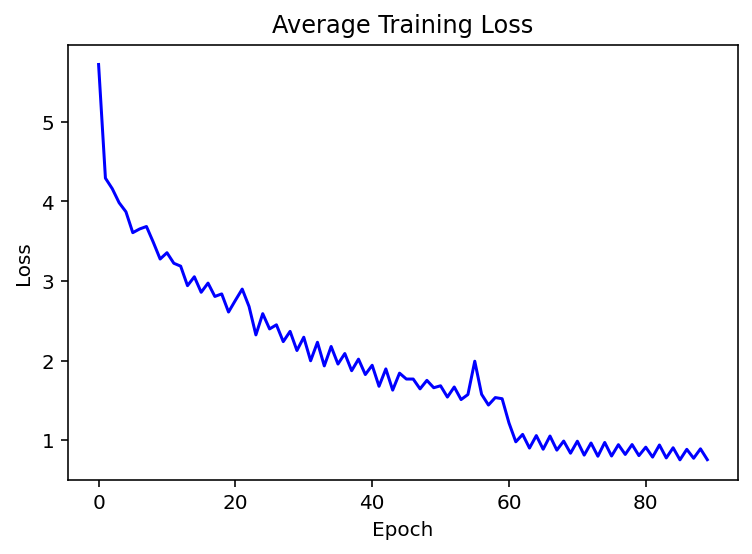

In [13]:
# tell wandb to get started
run = wandb.init(**wandb_init)

# make the model, data, and optimization problem
model_ft, criterion, optimizer, scheduler = make(config)

# and use them to train the model
model_ft = train_model(model_ft, criterion, optimizer, scheduler, config)

test_model(model_ft, criterion)

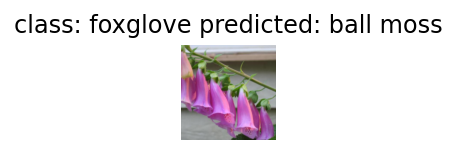

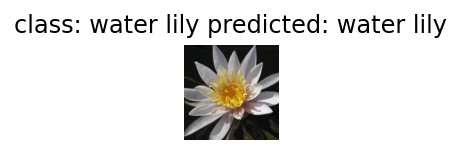

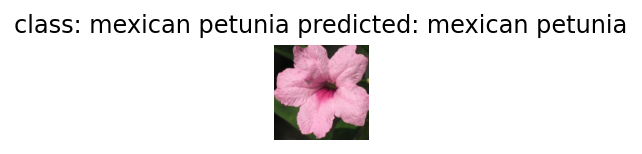

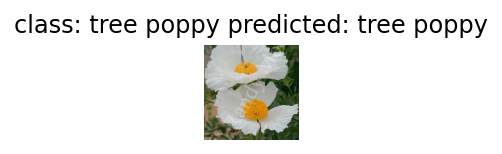

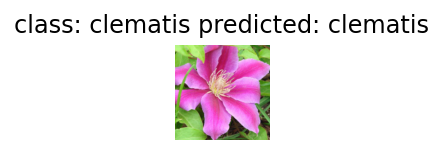

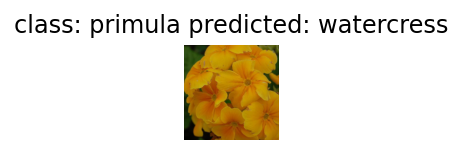

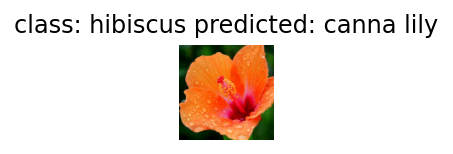

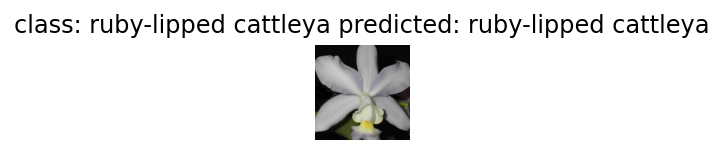

In [14]:
visualize_model(model_ft, num_images=8)

## Display the confusion matrix as a heatmap

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
preds = np.zeros((1))
truth = np.zeros((1))

model_ft.eval()
with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_ft(images.to(device))
        pred = outputs.argmax(dim=1)
        preds = np.concatenate([preds, pred.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.cpu().numpy()], axis=0)

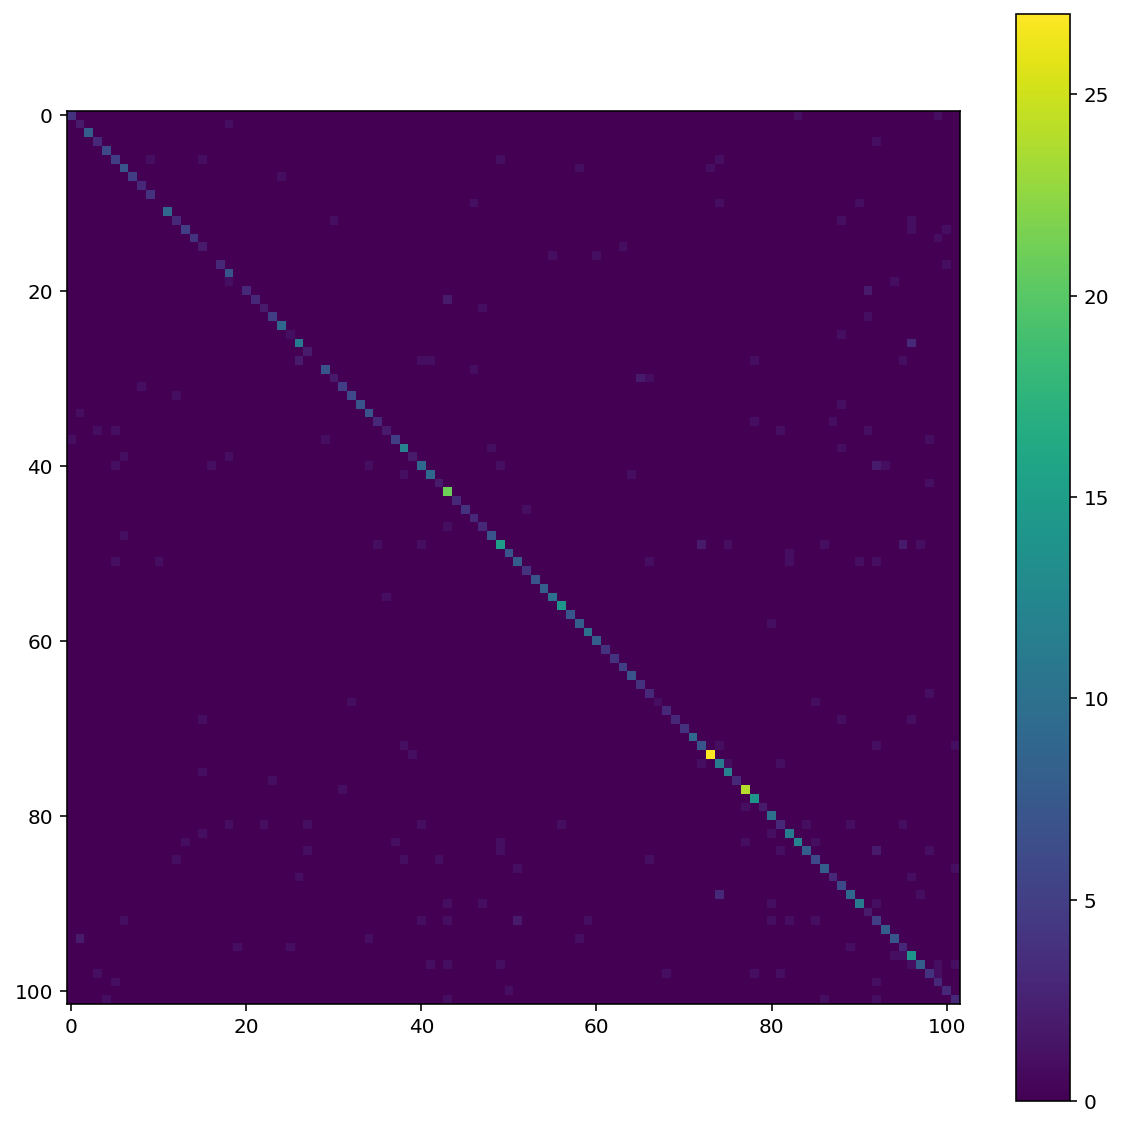

In [16]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
fig = plt.figure(figsize=(10,10))
plt.imshow(arr)
plt.colorbar()

## Some multi-class performance report defined from Scikit-learn

In [17]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names, zero_division=0))

                           precision    recall  f1-score   support

            pink primrose       0.80      0.67      0.73         6
            globe thistle       0.40      0.67      0.50         3
           blanket flower       1.00      1.00      1.00         8
          trumpet creeper       0.60      0.75      0.67         4
          blackberry lily       0.86      1.00      0.92         6
               snapdragon       0.56      0.56      0.56         9
              colt's foot       0.70      0.78      0.74         9
              king protea       1.00      0.83      0.91         6
            spear thistle       0.75      1.00      0.86         3
              yellow iris       0.80      1.00      0.89         4
             globe-flower       0.00      0.00      0.00         3
        purple coneflower       1.00      1.00      1.00         9
            peruvian lily       0.60      0.50      0.55         6
           balloon flower       0.83      0.71      0.77     

In [18]:
run.finish()